In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np
from scipy.optimize import curve_fit

In [3]:
insar_asc_u_corrected = r'insar/sentinel1_asc_t088_limburg_u_Kerkrade.csv'

insar_asc_u = pd.read_csv(insar_asc_u_corrected, sep=',')

In [4]:
insar_asc_u.head()

Unnamed: 0              pnt_id  pnt_flags    pnt_lat   pnt_lon  pnt_line  \
0     8666284  L00012395P00030381         11  50.830029  6.035176     12395   
1     8667671  L00012396P00030366        101  50.830063  6.034464     12396   
2     8667672  L00012396P00030367        101  50.830044  6.034565     12396   
3     8667673  L00012396P00030368        101  50.830071  6.034538     12396   
4     8667674  L00012396P00030369        101  50.830078  6.034555     12396   

   pnt_pixel  pnt_height  pnt_demheight  pnt_demheight_highres  ...  \
0      30381   215.67052      221.34067              221.34067  ...   
1      30366   222.71645      218.97993              218.97993  ...   
2      30367   224.24109      219.15625              219.15625  ...   
3      30368   222.49604      219.33257              219.33257  ...   
4      30369   220.54963      219.50887              219.50887  ...   

   u_20220713  u_20220725  u_20220806  u_20220818  u_20220830  u_20220911  \
0    0.000143   -0.007591   -0.002866   -0.004522    0.001900    0.001816   
1   -0.003404    0.000546   -0.005094   -0.004985   -0.002782   -0.003858   
2   -0.005691   -0.001681   -0.007170   -0.007632   -0.004926   -0.006414   
3   -0.003614    0.000908   -0.004707   -0.005279   -0.002959   -0.004867   
4   -0.002774    0.001328   -0.004110   -0.004522   -0.002665   -0.004354   

   u_20220923  u_20221005  u_20221017  u_20221029  
0    0.002068    0.004245   -0.001202    0.006347  
1   -0.004287   -0.011104   -0.003177   -0.007800  
2   -0.008666   -0.010373   -0.004934   -0.009675  
3   -0.004959   -0.013911   -0.002631   -0.007237  
4   -0.004623   -0.013743   -0.001614   -0.006708  

[5 rows x 175 columns]

In [5]:
# # Extract the dates from the .csv file
insar_dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (insar_dates - insar_dates[0]).days
years = days/365

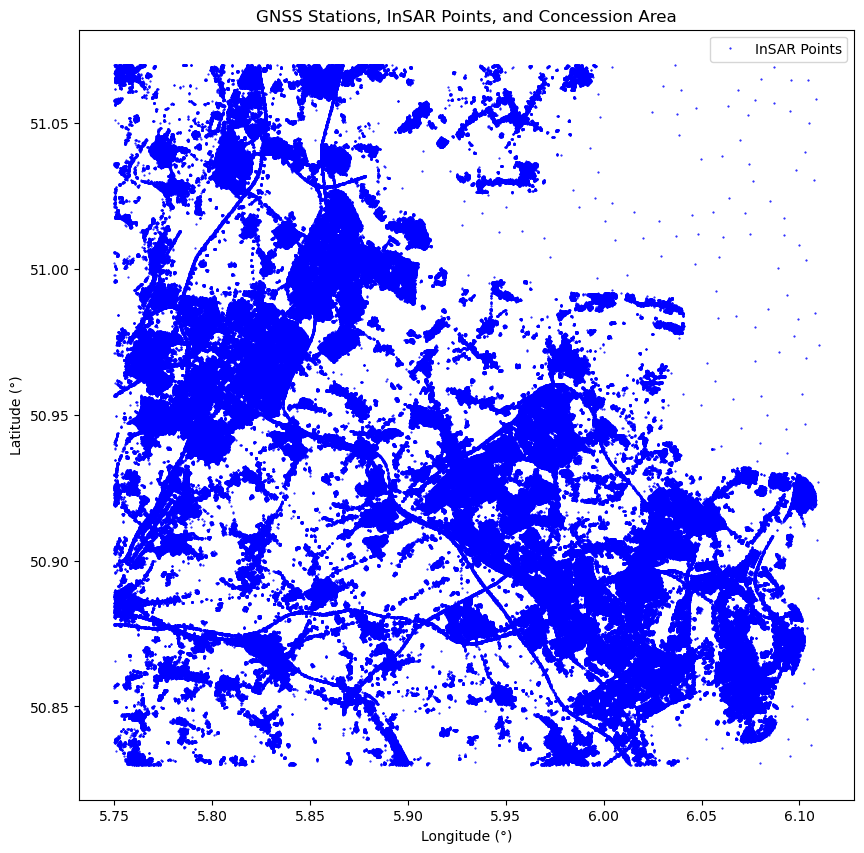

In [6]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)


# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

plt.show()


In [7]:
# Convert InSAR dates to t vector
insar_t = (insar_dates - insar_dates[0]).days.values

In [8]:
def linear_trend(t, a, b):
    return a + b * t

In [10]:
residuals_df = pd.DataFrame(
    index=disp_asc_u.index,
    columns=disp_asc_u.columns,
    dtype=float
)

for idx, row in disp_asc_u.iterrows():
    popt, _ = curve_fit(linear_trend, insar_t, row.values)
    u_hat = linear_trend(insar_t, *popt)
    residuals_df.loc[idx] = row.values - u_hat


KeyboardInterrupt: 

In [9]:
# loop over all InSAR points and calculate the trend model for each point

for index, row in disp_asc_u.iterrows():
    popt, pcov = curve_fit(linear_trend, insar_t, row.values)
    a_hat, b_hat = popt
    u_hat = linear_trend(insar_t, a_hat, b_hat)
    residuals = row.values - u_hat

u_20171001    0.000000
u_20171007    0.001101
u_20171019    0.004026
u_20171031    0.000908
u_20171112    0.000723
                ...   
u_20220911    0.001816
u_20220923    0.002068
u_20221005    0.004245
u_20221017   -0.001202
u_20221029    0.006347
Name: 0, Length: 155, dtype: float64
u_20171001    0.000000
u_20171007   -0.001000
u_20171019   -0.004867
u_20171031    0.000454
u_20171112   -0.002782
                ...   
u_20220911   -0.003858
u_20220923   -0.004287
u_20221005   -0.011104
u_20221017   -0.003177
u_20221029   -0.007800
Name: 1, Length: 155, dtype: float64
u_20171001    0.000000
u_20171007   -0.002362
u_20171019   -0.006741
u_20171031   -0.000723
u_20171112   -0.004800
                ...   
u_20220911   -0.006414
u_20220923   -0.008666
u_20221005   -0.010373
u_20221017   -0.004934
u_20221029   -0.009675
Name: 2, Length: 155, dtype: float64
u_20171001    0.000000
u_20171007   -0.001118
u_20171019   -0.004657
u_20171031    0.001311
u_20171112   -0.002581
               

KeyboardInterrupt: 